In [1]:
#!/usr/bin/env python3
import numpy as np
#import cPickle
import _pickle as cPickle #python3.x cPickle has changed from cPickle to _pickle or use pickle
import os
import gzip

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    
    try:
        #test = np.array(cPickle.load(f, encoding="latin1"))
        #for x in test:
        #    print("shape: {}".format(np.shape(x)))
        #train_set =test[0]
        #valid_set =test[1]
        #test_set = test[2]
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()
    #print ("train_set",train_set)
    #print ("valid_set",valid_set)
    #print ("test_set",test_set)
    test_x = test_set[0]
    test_y = test_set[1]
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [52]:

# start by defining simple helpers
# start by defining simple helpers
# ####################################
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    s = sigmoid(x)
    return s*(1-s)

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    t = np.tanh(x)**2
    return 1. - t

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    dx = np.zeros(x.shape)
    dx[x >= 0] = 1
    return dx
# ####################################

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname = None):
        #################################
        if tname is None:
            self.act = None
            self.act_d = None    
            return
        #################################
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        #################################
        if self.act is not None:
            return self.act(input)
        else:
            return input
        #################################
    
    def bprop(self, output_grad):
        #################################
        if self.act_d is not None:
            return output_grad * self.act_d(self.last_input)
        else:
            return output_grad #not multi wihth last in* self.last_input
        #################################

# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError()

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError()

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError()

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError()

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError()
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError()

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        #################################
        if self.activation_fun is None:
            self.activation_fun = Activation()
        # implement weight initialization
         # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.randn(self.input_shape[1], self.num_units) * init_stddev
        # and this is the bias vector of shape: (num_units)
        self.b =np.zeros(self.num_units)
        # ################################
   
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
     #  ################################################
    def _activation(self, act, val):
        if act is None:
            #print("warning linear system!")
            return val
        else:
            return act(val)
         #  ################################################
        
    def fprop(self, input):
        self.last_input = input
        #  ################################################
        # implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        pre_act = input @ self.W + self.b
        return self._activation(self.activation_fun.fprop, pre_act)

        #  ################################################
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """

        n = output_grad.shape[0]
        #print("FullyConnectedLayer bprop")
        # ################################
        #  implement backward propagation
                # HINT: you may have to divide the weights by n
        #       to make gradient checking work 
        #       (since you want to divide the loss by number of inputs)
                # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # the gradient wrt. the input should be calculated here
        output_grad_privious = self._activation(self.activation_fun.bprop, output_grad)
        # the gradient wrt. b should be stored as selfdb
        self.db = np.mean(output_grad_privious, axis = 0)
        # the gradient wrt. W should be stored as self.dW
        self.dW = self.last_input.T @ output_grad_privious / n

        return output_grad_privious @ self.W.T # input grad 
        #  ###############################
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
         # ####################################
        # implement gradient of squared loss
        #return Y_pred - Y
        return -(Y - Y_pred)
        # ####################################       


    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y - Y_pred)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # ####################################
        # implement gradient of squared loss
        #return Y_pred - Y
        return -(Y - Y_pred)
        # ####################################       


    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        # and Y_pred is softmax already
        eps = 1e-10
        out = Y_pred
        # negative log likelihood
        loss = -np.sum(Y * np.log(Y_pred + eps))
        return np.mean(loss / Y.shape[0])

In [92]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        # ##########################################
        #plots after the training
        self.train_error = [] 
        self.valid_error = [] 
        self.data_error_classification = [] 
        # ##########################################
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        Y_pred = X
        # ##########################################
        # implement forward pass through all layers
        for l in self.layers:
            Y_pred = l.fprop(Y_pred)#input sthe prev prediction
        return Y_pred 
        # ##########################################
        
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        # ##########################################
        #  implement backward pass through all layers
        #print("backpropagate")
        #for l in self.layers[upto::-1]:#reverse
        for l in reversed(self.layers[upto:-1]):
            next_grad = l.bprop(next_grad)
        # ##########################################
        return next_grad
    
    def classification_error(self, X, Y, save_index_error = False):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y

        if save_index_error:
            self.data_error_classification = X[error]#save img to plot later
        return np.mean(error)
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        # #####################################
        for b_n in range(n_batches):
            
            # Implement stochastic gradient descent here
            # (you can assume the inputs are already shuffled)
            
            # start by extracting a batch from X and Y
            start = b_n * batch_size
            end = start + batch_size
            #if end > X.shape[0]:
            #    end = X.shape[0]
            x_batch = X[start:end]
            y_batch = Y[start:end]
            # then forward and backward propagation
            self.backpropagate(y_batch, self.predict(x_batch))
            #update
            for layer in self.layers:
                if isinstance(layer, FullyConnectedLayer):
                    for params, grad_params in zip(layer.params(), layer.grad_params()):
                        params -= learning_rate * grad_params# HINT: layer.params() returns parameters *by reference*
            # #####################################
  
    
    def gd_epoch(self, X, Y, learning_rate = 1e-6):
        #error template note learning_rate as input in NeuralNetwork.train !
        #   ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
         self.sgd_epoch(X, Y, learning_rate, X.size[0]) #one b
        #   ##################################################

    
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True, do_print = True):

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_error = self.classification_error(X, Y)
            if do_print:
                print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))
            #  ##################################################
            # compute error on validation data:
            # simply make the function take validation data as input
            # and then compute errors here and print them

            valid_error = self.classification_error(X_valid, Y_valid, save_index_error = (max_epochs==e))
            if do_print:
                print('valid error {:.4f}'.format(valid_error))
            self.valid_error.append(valid_error)
            self.train_error.append(train_error)
            #  ##################################################
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    epsilon = 1e-4
                    loss_base = output_given_params(param_init)
                    #  ####################################
                    #  compute the gradient with respect to
                    #      the initial parameters in two ways:
                    #      1) with grad_given_params()
                    #      2) with finite differences 
                    #         using output_given_params()
                    #         (as discussed in the lecture)
                    #      if your implementation is correct 
                    #      both results should be epsilon close
                    #      to each other!
                      # making sure your gradient checking routine itself 
                    # has no errors can be a bit tricky. To debug it
                    # you can "cheat" by using scipy which implements
                    # gradient checking exactly the way you should!
                    # To do that simply run the following here:
                    #import scipy.optimize
                    #err = scipy.optimize.check_grad(output_given_params, 
                    #                                grad_given_params, param_init)
                    gparam_bprop = grad_given_params(param_init)
                    gparam_fd = np.zeros_like(param_init)
                    for i in range(len(param_init)):
                        param_init[i] += epsilon
                        gparam_fd[i] = (output_given_params(param_init) - loss_base) / (epsilon)
                        param_init[i] -= epsilon
                    
                    err = np.mean(np.abs(gparam_bprop - gparam_fd))
                    #  ####################################

                    print('diff {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [61]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [20]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [21]:

nn.check_gradients(X, Y)

checking gradient for layer 1
diff 3.63e-09
diff 3.90e-09
checking gradient for layer 2
diff 4.66e-09
diff 1.77e-07
checking gradient for layer 3
diff 1.28e-08
diff 4.64e-06


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [25]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 40000 # increased number of training data
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [26]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (40000, 1, 28, 28)
y_train shape: (40000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [27]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (40000, 784)
Reshaped X_valid size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [28]:
#shuffle the data with sklearn
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

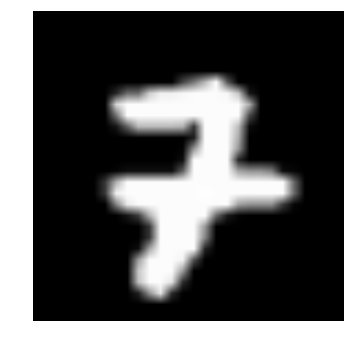

In [99]:
#visualization
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_number(data, ax = None):
    ''' helper to plot a number form the MNIST data set'''
    
    if ax is None:
        plt.axis('off')
        plt.imshow(np.reshape(data, (28, 28)), cmap=cm.gray, vmin=0, vmax=1)
    else:
        ax.set_axis_off()
        ax.imshow(np.reshape(data, (28, 28)), cmap=cm.gray, vmin=0, vmax=1)
    
    
def plt_nn_valid_error(network):
    ''' plt the valitastion error of the network '''
    print('last valid_error: {:.3f}'.format(network.valid_error[-1]))
    epoch_x = np.arange(len(network.valid_error))
    line_val, = plt.plot(epoch_x, network.valid_error, label="validation error")
    line_train, =  plt.plot(epoch_x, network.train_error, label="training error")
    plt.ylabel('error in percent')
    plt.xlabel('epochs')
    plt.legend(handles=[line_val, line_train])
    
#test to plot a number from the data set
plot_number(X_train[0])
    

... starting training
epoch 0.0000, loss 0.9713, train error 0.3437
valid error 0.3251
epoch 1.0000, loss 0.4188, train error 0.1218
valid error 0.1129
epoch 2.0000, loss 0.2525, train error 0.0709
valid error 0.0694
epoch 3.0000, loss 0.1831, train error 0.0519
valid error 0.0510
epoch 4.0000, loss 0.1448, train error 0.0413
valid error 0.0439
epoch 5.0000, loss 0.1251, train error 0.0368
valid error 0.0407
epoch 6.0000, loss 0.1109, train error 0.0331
valid error 0.0383
epoch 7.0000, loss 0.1004, train error 0.0300
valid error 0.0377
epoch 8.0000, loss 0.0880, train error 0.0266
valid error 0.0349
epoch 9.0000, loss 0.0800, train error 0.0239
valid error 0.0343
epoch 10.0000, loss 0.0734, train error 0.0222
valid error 0.0342
epoch 11.0000, loss 0.0671, train error 0.0205
valid error 0.0338
epoch 12.0000, loss 0.0632, train error 0.0195
valid error 0.0345
epoch 13.0000, loss 0.0602, train error 0.0186
valid error 0.0343
epoch 14.0000, loss 0.0552, train error 0.0170
valid error 0.034

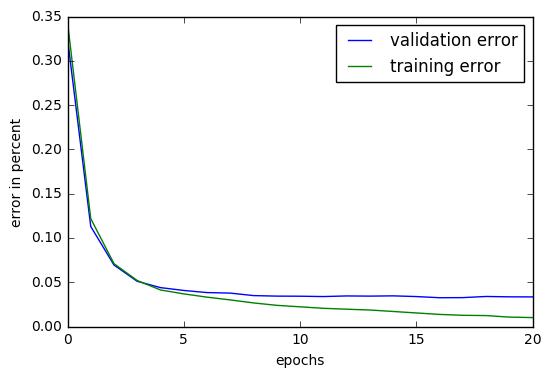

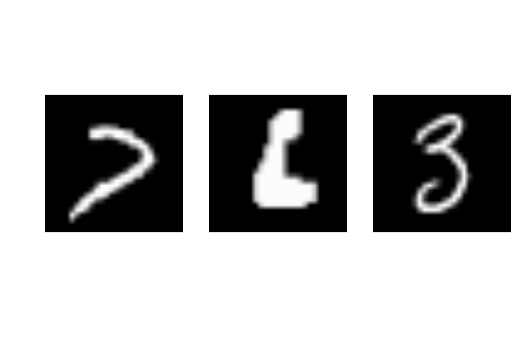

In [102]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
# all hyperparameter for the exercice template
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=50,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=50,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.1, 
         max_epochs=20, batch_size=64, y_one_hot=True)
plt_nn_valid_error(nn)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

#print some wrong classified digets
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
plot_number(nn.data_error_classification[0],ax1) 
plot_number(nn.data_error_classification[1],ax2) 
plot_number(nn.data_error_classification[3],ax3)

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Once you have done this, visualize a few digits from the the test set that the network gets right as well as a few that the network gets wrong!

good performance acheved by:
- increase the number of units to a higher value of fit the data better
- therefore the model is more complex -> the learning rate was reduced
- disadvantage the training takes way longer
- impovement fom an valid erro form to r 0.0569
- init_stddev 0.01

In [104]:
def creat_layer(act_func_str, num_fully_connected =[100, 100], init_stddev =0.01):
    '''helper to creat mulitple layers for the MNIST dataset'''
    input_shape = (None, 28*28)
    layers = [InputLayer(input_shape)]

    #creat all FullyConnectedLayer layers
    for num_units in num_fully_connected:
          layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units = num_units,
                    init_stddev = init_stddev,
                    activation_fun=Activation(act_func_str)
        ))  
    layers.append(FullyConnectedLayer(
                    layers[-1],
                    num_units=10,
                    init_stddev=init_stddev,
                    # last layer has no nonlinearity 
                    # (softmax will be applied in the output layer)
                    activation_fun = None 
    ))
    layers.append(SoftmaxOutput(layers[-1]))
    return layers

... starting training
last valid_error: 0.101
Duration: 25.3s


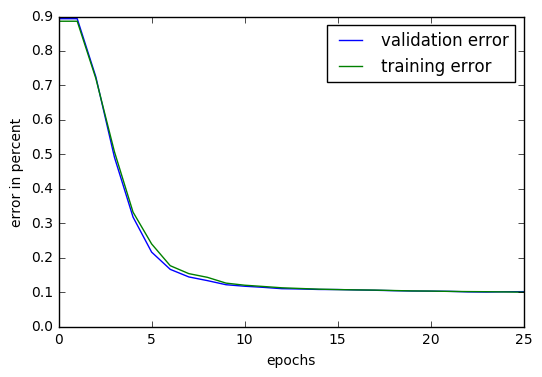

In [108]:
# Setup a dpper MLP / Neural Network
layers = creat_layer(num_fully_connected =[200, 200], 
                     act_func_str = "relu")

nn_deeper = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn_deeper.train(X_train, y_train, X_valid, y_valid, learning_rate= 0.1, 
         max_epochs=25, batch_size=100, y_one_hot=True, do_print = False)
plt_nn_valid_error(nn_deeper) 
print('Duration: {:.1f}s'.format(time.time()-t0))

# hyper parameter optimization with Tree of Parzen Estimators (TPE)
now we use Tree of Parzen Estimators to find good parameter for:
- learningrate
- activation function
- number of fully connected layers and hidden units 
- number of epochs
we use https://github.com/hyperopt/hyperopt libary for the optimization

In [16]:
import hyperopt
from hyperopt import hp
from pprint import pprint
from functools import partial
from math import  log

In [17]:
def sample_loss_hyperopt(param):
    print("===========================================")
    print("Parameters:")
    print(param)
    layer_sizes = [int(n) for n in param['layers']['n_units_layer']]
    lr = param['lr']
    act_func_type = param['act_func_type']
    epochs = int(param['epochs'])
    layers = creat_layer(num_fully_connected = layer_sizes, 
                     act_func_str = act_func_type)
    nn = NeuralNetwork(layers)
    # Train neural network
    t0 = time.time()
    nn.train(X_train, y_train, X_valid, y_valid, learning_rate= lr, 
             max_epochs = epochs, batch_size=100, y_one_hot=True, do_print = False)
    print('valid_error: {:.3f}'.format(nn.valid_error[-1]))
    return nn.valid_error[-1]

def optimize_hyperopt():
    '''define our parameters in hyperopt and run the optimization.'''
    parameter_space = {
        #learning rate
        'lr':hp.loguniform('lr',log(1e-2) , log(1e-1 )),
         'epochs': hp.choice('epochs', [
            10, 15, 20
        ]),
        'act_func_type': hp.choice('act_func_type', [
            'sigmoid',
            'tanh',
            'relu'
        ]),
        #choose between one or two layers
        'layers': hp.choice('layers', [{
            'n_layers': 1,
            'n_units_layer': [
                hp.quniform('n_units_layer_11', 50, 500, q=1),
            ],
        }, {
            'n_layers': 2,
            'n_units_layer': [
                hp.quniform('n_units_layer_21', 50, 200, q=1),
                hp.quniform('n_units_layer_22', 50, 200, q=1),
            ],
        }, {
            'n_layers': 3,
            'n_units_layer': [
                hp.quniform('n_units_layer_31', 50, 200, q=1),
                hp.quniform('n_units_layer_32', 50, 200, q=1),
                hp.quniform('n_units_layer_33', 50, 200, q=1),
            ],
        }
        ])
    }
    #Tree of Parzen Estimators (TPE)
    tpe = partial(
        hyperopt.tpe.suggest,
        n_EI_candidates=100,# Sample 100 candidate and select candidate that# has highest Expected Improvement (EI)
        gamma=0.2,# Use 20% of best observations to estimate next# set of parameters
        n_startup_jobs=20,# First 20 trials are going to be random
    )
    best_model = hyperopt.fmin(sample_loss_hyperopt,
                               space = parameter_space,
                               algo = tpe,
                               # algo=tpe.suggest,
                               max_evals=1000)

    print(best_model)
    print(hyperopt.space_eval(parameter_space, best_model))

In [18]:
t0 = time.time()
#optimize_hyperopt()
print('Duration: {:.1f}s'.format(time.time()-t0))

Parameters:
{'act_func_type': 'sigmoid', 'epochs': 40, 'lr': 0.017168444898934574, 'layers': {'n_layers': 2, 'n_units_layer': (95.0, 105.0)}}
... starting training
valid_error: 0.894
Parameters:
{'act_func_type': 'relu', 'epochs': 40, 'lr': 0.04326519574181773, 'layers': {'n_layers': 1, 'n_units_layer': (75.0,)}}
... starting training
valid_error: 0.066
Parameters:
{'act_func_type': 'sigmoid', 'epochs': 40, 'lr': 0.027890788535983823, 'layers': {'n_layers': 3, 'n_units_layer': (70.0, 190.0, 84.0)}}
... starting training
valid_error: 0.894
Parameters:
{'act_func_type': 'sigmoid', 'epochs': 20, 'lr': 0.01417751049300607, 'layers': {'n_layers': 3, 'n_units_layer': (135.0, 179.0, 94.0)}}
... starting training
valid_error: 0.894
Parameters:
{'act_func_type': 'relu', 'epochs': 40, 'lr': 0.02875391711709507, 'layers': {'n_layers': 3, 'n_units_layer': (91.0, 75.0, 140.0)}}
... starting training


KeyboardInterrupt: 

... starting training
last valid_error: 0.028
Duration: 66.8s


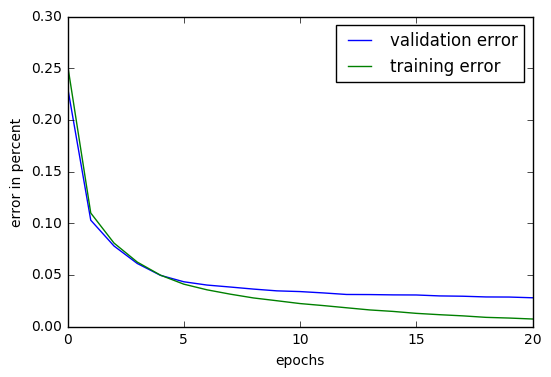

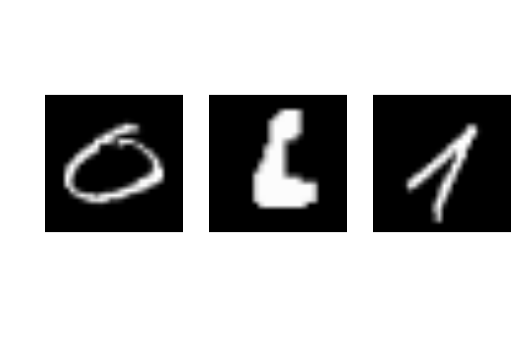

In [117]:
# Setup the best nn from the opitmation
hyperopt_layers = creat_layer(num_fully_connected =[147, 161], 
                     act_func_str = "relu")

nn_hyperopt = NeuralNetwork(hyperopt_layers)
# Train neural network
t0 = time.time()
nn_hyperopt.train(X_train, y_train, X_valid, y_valid, learning_rate= 0.09952244971405384, 
         max_epochs=20, batch_size=100, y_one_hot = True, do_print = False)
plt_nn_valid_error(nn_hyperopt) 
print('Duration: {:.1f}s'.format(time.time() - t0))

#print some wrong classified digets
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
plot_number(nn_hyperopt.data_error_classification[0],ax1) 
plot_number(nn_hyperopt.data_error_classification[1],ax2) 
plot_number(nn_hyperopt.data_error_classification[3],ax3)